In [1]:
import pandas as pd

In [4]:
pwd

'/home/estebanelia/labo/experiments'

In [6]:
df = pd.read_csv('../../buckets/b1/exp/downsampled_dataset_final.csv')
df.drop(columns=['azar'], inplace=True)

In [7]:
train_data = df[df['fold_train'] ==1]
valid_data = df[df['fold_validate'] ==1]
test_data = df[df['fold_test'] ==1]

In [8]:
train_data['clase_ternaria'].value_counts()

clase_ternaria
0    14042
2     7219
1     6823
Name: count, dtype: int64

In [22]:
import random
import pandas as pd

import time
import lightgbm as lgb
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


def rolling_window_df(df, window_size=0.3, step_size=0.10, max_datasets=6):
    num_cols = len(df.columns)
    window_cols = int(num_cols * window_size)
    step_cols = int(num_cols * step_size)
    
    result = []
    
    for start_col in range(0, num_cols, step_cols):
        if max_datasets and len(result) >= max_datasets:
            break
            
        end_col = start_col + window_cols
        if end_col > num_cols:
            break
            
        result.append(df.iloc[:, start_col:end_col])        
    return result


def lgb_objective(trial, X_train, y_train):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'custom',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'force_row_wise': True,
        'verbosity': -100,
        'max_depth': -1,
        'min_gain_to_split': 0.0,
        'min_sum_hessian_in_leaf': 0.001,
        'lambda_l1': 0.0,
        'lambda_l2': 0.0,
        'max_bin': 31,
        #'num_iterations': 9999,
        'bagging_fraction': 1.0,
        'pos_bagging_fraction': 1.0,
        'neg_bagging_fraction': 1.0,
        'is_unbalance': False,
        'scale_pos_weight': 1.0,
        'drop_rate': 0.1,
        'max_drop': 50,
        'skip_drop': 0.5,
        'extra_trees': True,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.01, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 4, 1024),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50000),
    }
    scores = cross_val_score(lgb.LGBMClassifier(**params), X_train, y_train, cv=3, scoring='roc_auc')
    return scores.mean()

def etc_objective(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
    }
    scores = cross_val_score(ExtraTreesClassifier(**params), X_train, y_train, cv=3, scoring='roc_auc')
    return scores.mean()

def experiments(X_train, y_train, X_test, y_test, seeds, n_trials=1, n_top = 12000):
    results_df = pd.DataFrame(columns=['seed', 'model', 'training_time', 'f1_score', 'mcc', 'auc', 'ganancia_custom'])
    imputer = SimpleImputer(strategy='mean')   
    
    y_test_baja = y_test.copy()
    y_train = y_train.replace({2:1})      
    y_test = y_test.replace({2:1})
    
    X_test = X_test[X_train.columns]    

    for seed in seeds:    
        np.random.seed(seed)
        print(f'Experiment with seed {seed}')    

        start_time = time.time()
        lgb_study = optuna.create_study(direction='maximize')
        lgb_study.optimize(lambda trial: lgb_objective(trial, X_train, y_train), n_trials=n_trials)
        lgb_model = lgb.LGBMClassifier(**lgb_study.best_params)
        lgb_model.fit(X_train, y_train)
        training_time = time.time() - start_time     

        y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]
        threshold = np.sort(y_pred_proba)[-n_top]
        y_pred = (y_pred_proba >= threshold).astype(int)

        results = pd.DataFrame({
            'seed': [seed],
            'model': ['LightGBM'],
            'training_time': [training_time],
            'f1_score': [f1_score(y_test, y_pred)],
            'mcc': [matthews_corrcoef(y_test, y_pred)],
            'auc': [roc_auc_score(y_test, y_pred_proba)],
            'ganancia_custom': [ganancia_custom(y_test_baja, y_pred)]
        })

        results_df = pd.concat([results_df, results], ignore_index=True)
        
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        start_time = time.time()
        etc_model_default = ExtraTreesClassifier(random_state=seed,n_jobs=-1)
        etc_model_default.fit(X_train, y_train)
        training_time = time.time() - start_time

        y_pred_proba = etc_model_default.predict_proba(X_test)[:, 1]
        threshold = np.sort(y_pred_proba)[-n_top]
        y_pred = (y_pred_proba >= threshold).astype(int)

        results = pd.DataFrame({
            'seed': [seed],
            'model': ['ExtraTreesDefault'],
            'training_time': [training_time],
            'f1_score': [f1_score(y_test, y_pred)],
            'mcc': [matthews_corrcoef(y_test, y_pred)],
            'auc': [roc_auc_score(y_test, y_pred_proba)],
            'ganancia_custom': [ganancia_custom(y_test_baja, y_pred)]
        })      
        results_df = pd.concat([results_df, results], ignore_index=True)   

        
        start_time = time.time()
        etc_study = optuna.create_study(direction='maximize')
        etc_study.optimize(lambda trial: etc_objective(trial, X_train, y_train), n_trials=n_trials)
        etc_model = ExtraTreesClassifier(n_jobs=-1, **etc_study.best_params)
        etc_model.fit(X_train, y_train)
        training_time = time.time() - start_time

        y_pred_proba = etc_model.predict_proba(X_test)[:, 1]
        threshold = np.sort(y_pred_proba)[-n_top]
        y_pred = (y_pred_proba >= threshold).astype(int)

        results = pd.DataFrame({
            'seed': [seed],
            'model': ['ExtraTreesOptimized'],
            'training_time': [training_time],
            'f1_score': [f1_score(y_test, y_pred)],
            'mcc': [matthews_corrcoef(y_test, y_pred)],
            'auc': [roc_auc_score(y_test, y_pred_proba)],
            'ganancia_custom': [ganancia_custom(y_test_baja, y_pred)]
        })
        results_df = pd.concat([results_df, results], ignore_index=True)   
    return results_df

In [14]:
X_valid = valid_data.drop(columns='clase_ternaria')
y_valid = valid_data['clase_ternaria']

X_test = test_data.drop(columns='clase_ternaria')
y_test = test_data['clase_ternaria']

X_train = train_data.drop(columns='clase_ternaria')
y_train = train_data['clase_ternaria']

## get feature importance

In [15]:
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)
importances_lgbm = lgbm_model.feature_importances_
feature_importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances_lgbm})
feature_importances_df.sort_values('importance', ascending=False, inplace=True)
X_train.columns = feature_importances_df['feature'].values

## build datasets

In [16]:
## datasets
dataset_1 = X_train.iloc[:,:int(X_train.shape[1]*0.3)]
dataset_2 = X_train.iloc[:,int(X_train.shape[1]*0.6):]
dataset_3 = X_train[random.sample(X_train.columns.to_list(), k=int(X_train.shape[1]*0.3))]

dataset_rolling = rolling_window_df(X_train)
dataset_4 = dataset_rolling[1]
dataset_5 = dataset_rolling[2]
dataset_6 = dataset_rolling[3]
dataset_7 = dataset_rolling[4]
dataset_8 = dataset_rolling[5]

dataset_9 = pd.concat([X_train.iloc[:,:int(X_train.shape[1]*0.15)],X_train.iloc[:,int(X_train.shape[1]*0.85):]])
dataset_10 = X_train[list(set(X_train.columns) - set(dataset_9.columns))]

# experiments

In [17]:
import numpy as np

def ganancia_custom(y_true, y_pred):
    # y_pred == 1 means we predict the positive class
    # Now we assign a gain/cost to each prediction
    conditions = [
        (y_pred == 1) & (y_true == 2),  # add 117000
        (y_pred == 1) & (y_true != 2),  # subtract 3000
        (y_pred == 0)  # add 0
    ]
    choices = [117000, -3000, 0]
    gan = np.select(conditions, choices)
    # Then we calculate the total gain
    total_gan = np.sum(gan)
    return total_gan

In [18]:
seeds = [677213, 727817,311237, 660719, 106427]

In [ ]:
datasets = [dataset_1, dataset_2]  # replace ... with your actual datasets
results = []

for i, dataset in enumerate(datasets, start=1):
    result = experiments(dataset, y_train, X_test, y_test, seeds, n_trials=1)
    results.append(result)


[I 2023-05-20 03:37:22,335] A new study created in memory with name: no-name-b854c645-d2e2-4bf1-af5c-6dbaa194d266


Experiment with seed 677213
[LightGBM] [Warning] feature_fraction is set=0.6033594576917648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6033594576917648
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set=24759, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24759
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.6033594576917648, colsample_bytree=1.0 will be igno

[I 2023-05-20 03:37:23,017] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 0.2703421520642212, 'feature_fraction': 0.6033594576917648, 'num_leaves': 540, 'min_data_in_leaf': 24759}. Best is trial 0 with value: 0.5.


[LightGBM] [Warning] feature_fraction is set=0.6033594576917648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6033594576917648
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set=24759, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24759
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.6033594576917648, colsample_bytree=1.0 will be ignored. Current value: feature_

[I 2023-05-20 03:37:25,262] A new study created in memory with name: no-name-fa1bcfa4-ac11-4287-8c85-6956345892b6


In [14]:
results_experiment_11 = experiments(X_train, y_train, X_test, y_test, seeds, n_trials = 1)

/tmp/ipykernel_31/685582060.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.loc[:] = y_train.replace({2:1}).copy()
/tmp/ipykernel_31/685582060.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:] = y_test.replace({2:1}).copy()
[I 2023-05-20 01:45:24,081] A new study created in memory with name: no-name-a81445d3-112f-4e27-b0a3-a401038e602c


Experiment with seed 677213
[LightGBM] [Warning] feature_fraction is set=0.028591718732675978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.028591718732675978
[LightGBM] [Warning] min_data_in_leaf is set=1931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1931
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.028591718732675978, colsample_bytree=1.0 will be 

[I 2023-05-20 01:45:30,851] Trial 0 finished with value: 0.8892414529964913 and parameters: {'learning_rate': 0.054750556801834806, 'feature_fraction': 0.028591718732675978, 'num_leaves': 129, 'min_data_in_leaf': 1931}. Best is trial 0 with value: 0.8892414529964913.


[LightGBM] [Warning] min_data_in_leaf is set=1931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1931
[LightGBM] [Warning] feature_fraction is set=0.028591718732675978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.028591718732675978


/tmp/ipykernel_31/685582060.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_31/685582060.py:166: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [15]:
results_experiment_11

,seed,model,training_time,f1_score,mcc,auc,ganancia_custom
0,677213,LightGBM,15.996934,0.109347,0.114264,0.792865,16320000
1,677213,ExtraTreesDefault,16.381230,0.038366,0.020903,0.566335,-19050000


In [110]:
results_experiment_1

,seed,model,training_time,f1_score,mcc,auc,ganancia_custom
0,677213,LightGBM,10.628186,0.028091,0.000000,0.500000,-494046000
1,677213,ExtraTreesDefault,17.107150,0.035386,0.060897,0.913337,-388203000
2,727817,LightGBM,12.019610,0.028091,0.000000,0.500000,-494046000
3,727817,ExtraTreesDefault,17.147733,0.035342,0.061011,0.913560,-389541000
4,311237,LightGBM,4.694838,0.028091,0.000000,0.500000,-494046000
5,311237,ExtraTreesDefault,16.847061,0.034986,0.059342,0.912908,-393234000
6,660719,LightGBM,4.700524,0.028091,0.000000,0.500000,-494046000
7,660719,ExtraTreesDefault,17.471278,0.035257,0.060404,0.912641,-389814000
8,106427,LightGBM,12.008998,0.048822,0.103107,0.917248,-277710000
9,106427,ExtraTreesDefault,16.484745,0.035452,0.061361,0.912893,-387972000


In [103]:
results_experiment_1

,seed,model,training_time,f1_score,mcc,auc,ganancia_custom
0,677213,LightGBM,4.790954,0.028091,0.000000,0.500000,-341886000
1,677213,ExtraTreesDefault,6.688642,0.028091,0.000000,0.582855,-494046000
2,727817,LightGBM,7.906892,0.028091,0.000000,0.231468,-341886000
3,727817,ExtraTreesDefault,7.287828,0.028091,0.000000,0.544869,-494046000
4,311237,LightGBM,9.124369,0.028151,0.004476,0.553058,-340413000
5,311237,ExtraTreesDefault,7.559847,0.028091,0.000000,0.505853,-494046000
6,660719,LightGBM,4.344935,0.028091,0.000000,0.500000,-341886000
7,660719,ExtraTreesDefault,7.345021,0.028091,0.000000,0.524286,-494046000
8,106427,LightGBM,4.390207,0.028091,0.000000,0.500000,-341886000
9,106427,ExtraTreesDefault,6.863296,0.028091,0.000000,0.515562,-494046000


/tmp/ipykernel_32/3128785517.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="model", y="f1_score", data=results_experiment_1, ci=None)


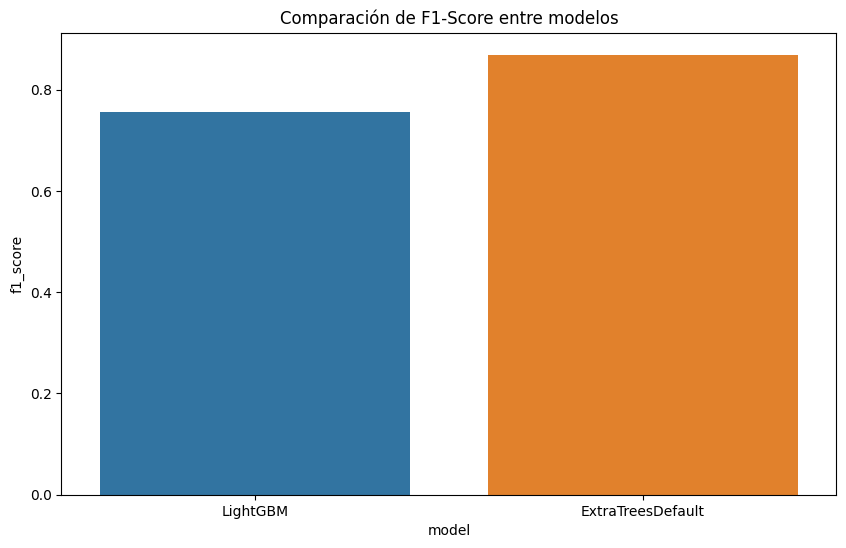

/tmp/ipykernel_32/3128785517.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="model", y="mcc", data=results_experiment_1, ci=None)


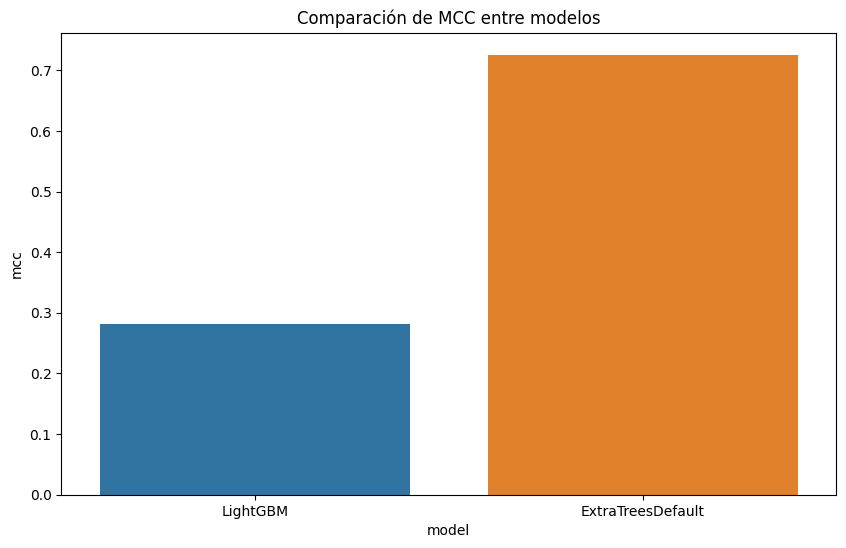

/tmp/ipykernel_32/3128785517.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="model", y="auc", data=results_experiment_1, ci=None)


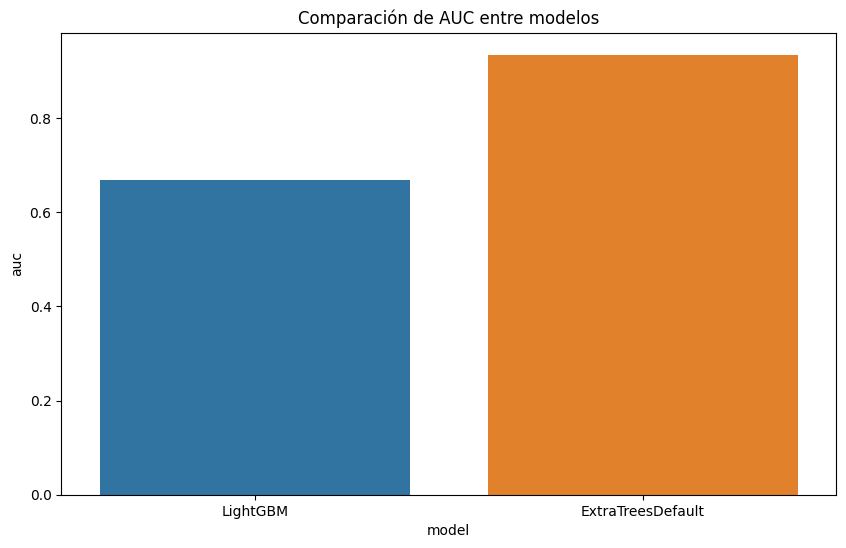

In [88]:
# F1-Score
plt.figure(figsize=(10, 6))
sns.barplot(x="model", y="f1_score", data=results_experiment_1, ci=None)
plt.title("Comparación de F1-Score entre modelos")
plt.show()

# MCC
plt.figure(figsize=(10, 6))
sns.barplot(x="model", y="mcc", data=results_experiment_1, ci=None)
plt.title("Comparación de MCC entre modelos")
plt.show()

# AUC
plt.figure(figsize=(10, 6))
sns.barplot(x="model", y="auc", data=results_experiment_1, ci=None)
plt.title("Comparación de AUC entre modelos")
plt.show()


In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

def barplot(df, metrica):    
    plt.figure(figsize=(10, 6))
    sns.barplot(x="model", y=metrica, data=df)
    plt.title(f"Comparación de {metrica} entre modelos")
    plt.show()    
    
def correlacion(df, metrica):
    data_wide_1 = df[df["model"]=="LightGBM"][["seed", metrica]].rename(columns={metrica: f"{metrica}_LightGBM"})
    data_wide_2 = df[df["model"]=="ExtraTreesDefault"][["seed", metrica]].rename(columns={metrica: f"{metrica}_ExtraTrees"})
    data_wide = pd.merge(data_wide_1, data_wide_2, on="seed")
    correlation_pearson = data_wide[f"{metrica}_LightGBM"].corr(data_wide[f"{metrica}_ExtraTrees"], method='pearson')
    print(f'Pearson correlation: {correlation_pearson}')
    correlation_spearman = data_wide[f"{metrica}_LightGBM"].corr(data_wide[f"{metrica}_ExtraTrees"], method='spearman')
    print(f'Spearman correlation: {correlation_spearman}')

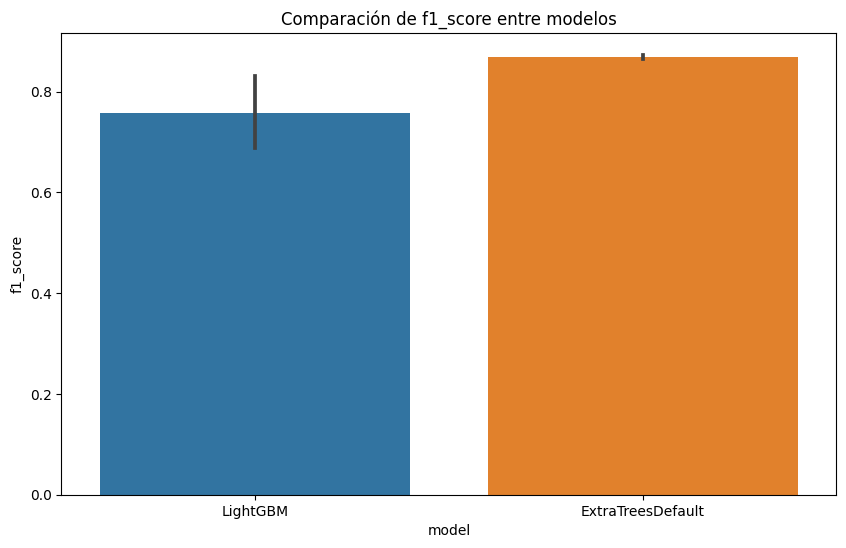

In [118]:
barplot(results_experiment_1,'f1_score')

In [113]:
correlacion(results_experiment_1,'auc')

Pearson correlation: -0.36211518340156246
Spearman correlation: -0.4472135954999579


In [112]:
correlacion(results_experiment_1,'auc')

Pearson correlation: -0.31457637081472845
Spearman correlation: -0.22360679774997896


In [114]:
results_experiment_1

,seed,model,training_time,f1_score,mcc,auc,ganancia_custom
0,677213,LightGBM,10.778766,0.691342,0.000000,0.500000,0.528283
1,677213,ExtraTreesDefault,6.015139,0.876861,0.738775,0.938406,0.869815
2,727817,LightGBM,19.698008,0.685702,0.000000,0.500000,0.521725
3,727817,ExtraTreesDefault,6.345924,0.862658,0.715078,0.931974,0.857682
4,311237,LightGBM,30.474817,0.875383,0.731866,0.937011,0.866535
5,311237,ExtraTreesDefault,6.065432,0.870093,0.725899,0.936544,0.863256
6,660719,LightGBM,16.402433,0.842205,0.671944,0.908717,0.836203
7,660719,ExtraTreesDefault,6.903919,0.864334,0.718655,0.930209,0.859485
8,106427,LightGBM,13.265439,0.689092,0.000000,0.500000,0.525660
9,106427,ExtraTreesDefault,5.975341,0.871160,0.729922,0.937436,0.865224
